In [1]:
import sys
sys.path.append('/home/monte.flora/python_packages/scikit-explain/')
sys.path.append('/home/monte.flora/python_packages/master/ml_workflow')

import skexplain
import shap
from skexplain.plot.base_plotting import PlotStructure
import numpy as np
sys.path.append('/home/monte.flora/python_packages/wofs_ml_severe/wofs_ml_severe/explain')
from display_names import to_readable_names, get_units
from load_model_and_data import loader, known_skew
from os.path import join
import pickle
import pandas as pd

In [2]:
lead_time = 'first_hour'
target = 'severe_hail'

(estimator, 
 predictions,
     X, y, 
     init_times, 
     test_dates,
    fti) = loader(lead_time, target, return_model=True)

feature_names = X.columns
display_feature_names = {f : to_readable_names(f) for f in feature_names}
display_units = {f : get_units(f) for f in feature_names}

In [3]:
import xarray as xr
def to_xarray(shap_data, estimator_name, feature_names=None):
    dataset={}
    
    shap_values = shap_data['shap_values']
    bias = shap_data['bias']
    
    dataset[f'shap_values__{estimator_name}'] = (['n_examples', 'n_features'], shap_values)
    dataset[f'bias__{estimator_name}'] = (['n_examples'], bias.astype(np.float64))
    dataset['X'] = (['n_examples', 'n_features'], shap_data['X'])
    dataset['y'] = (['n_examples'], shap_data['targets'])
    
    ds = xr.Dataset(dataset)
    #ds.attrs['features'] = feature_names
    
    return ds 

In [7]:
explainer = skexplain.ExplainToolkit(X=X, estimator_output='probability')

In [13]:
base_path = '/work/mflora/ML_DATA/'

# shap results
fname = join(base_path, 'SHAP_VALUES', f'shap_values_LogisticRegression_{target}_first_hour.pkl')
with open(fname, 'rb') as f:
    shap_data = pickle.load(f)
    
shap_ds = to_xarray(shap_data, estimator_name='LogisticRegression' )
explainer.X = pd.DataFrame(shap_ds['X'], columns=feature_names)
    
# ale results
ale_fname = join(base_path,'ALE_RESULTS', f'ale_results_all_models_{target}_first_hour.nc')
ale_results = explainer.load(ale_fname)

113 106
113 106


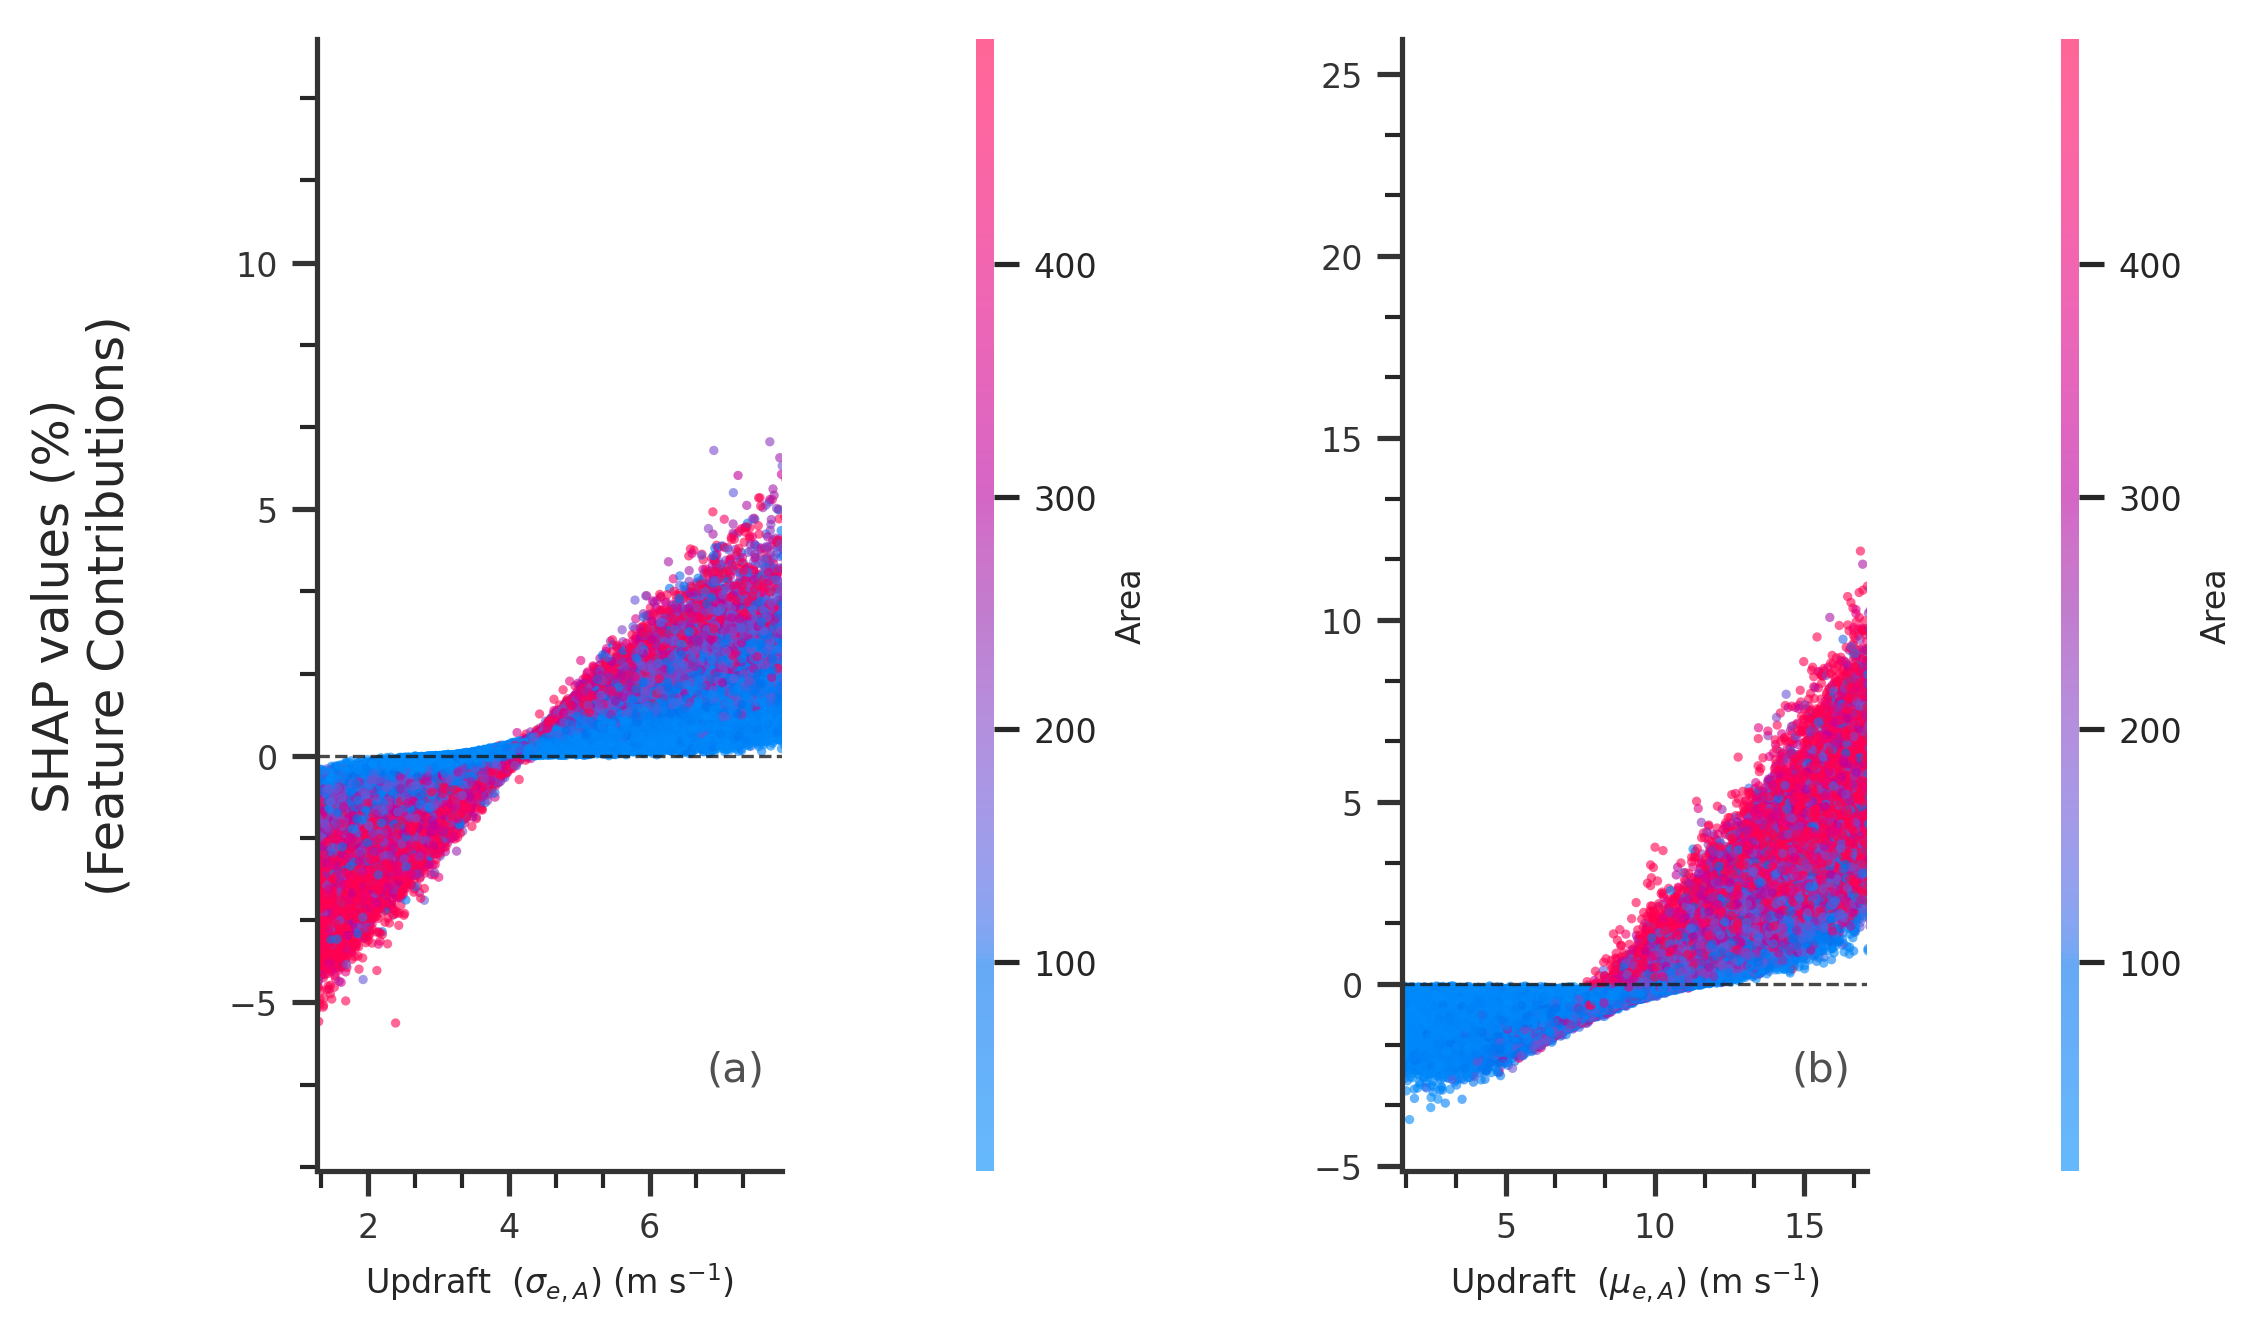

In [15]:
#display_feature_names = [display_feature_names[f] for f in feature_names]
features=['w_up_time_max_ens_std_of_90th', 
           'w_up_time_max_ens_mean_of_90th'
          ]

explainer.plot_shap(features=features,
                    plot_type = 'dependence',
                    shap_values=shap_ds,
                    estimator_name = 'LogisticRegression',
                    display_feature_names=display_feature_names,
                    display_units = display_units,
                    interaction_index='auto',
                    s = 5, 
                    alpha=0.6,
                    to_probability=True,
                    colorbar_pad = 0.25    
    )

(<Figure size 2400x1200 with 6 Axes>,
 array([<AxesSubplot:xlabel='Updraft  ($\\sigma_{e,A}$) (m s$^{-1}$)'>,
        <AxesSubplot:xlabel='Updraft  ($\\mu_{e,A}$) (m s$^{-1}$)'>],
       dtype=object))

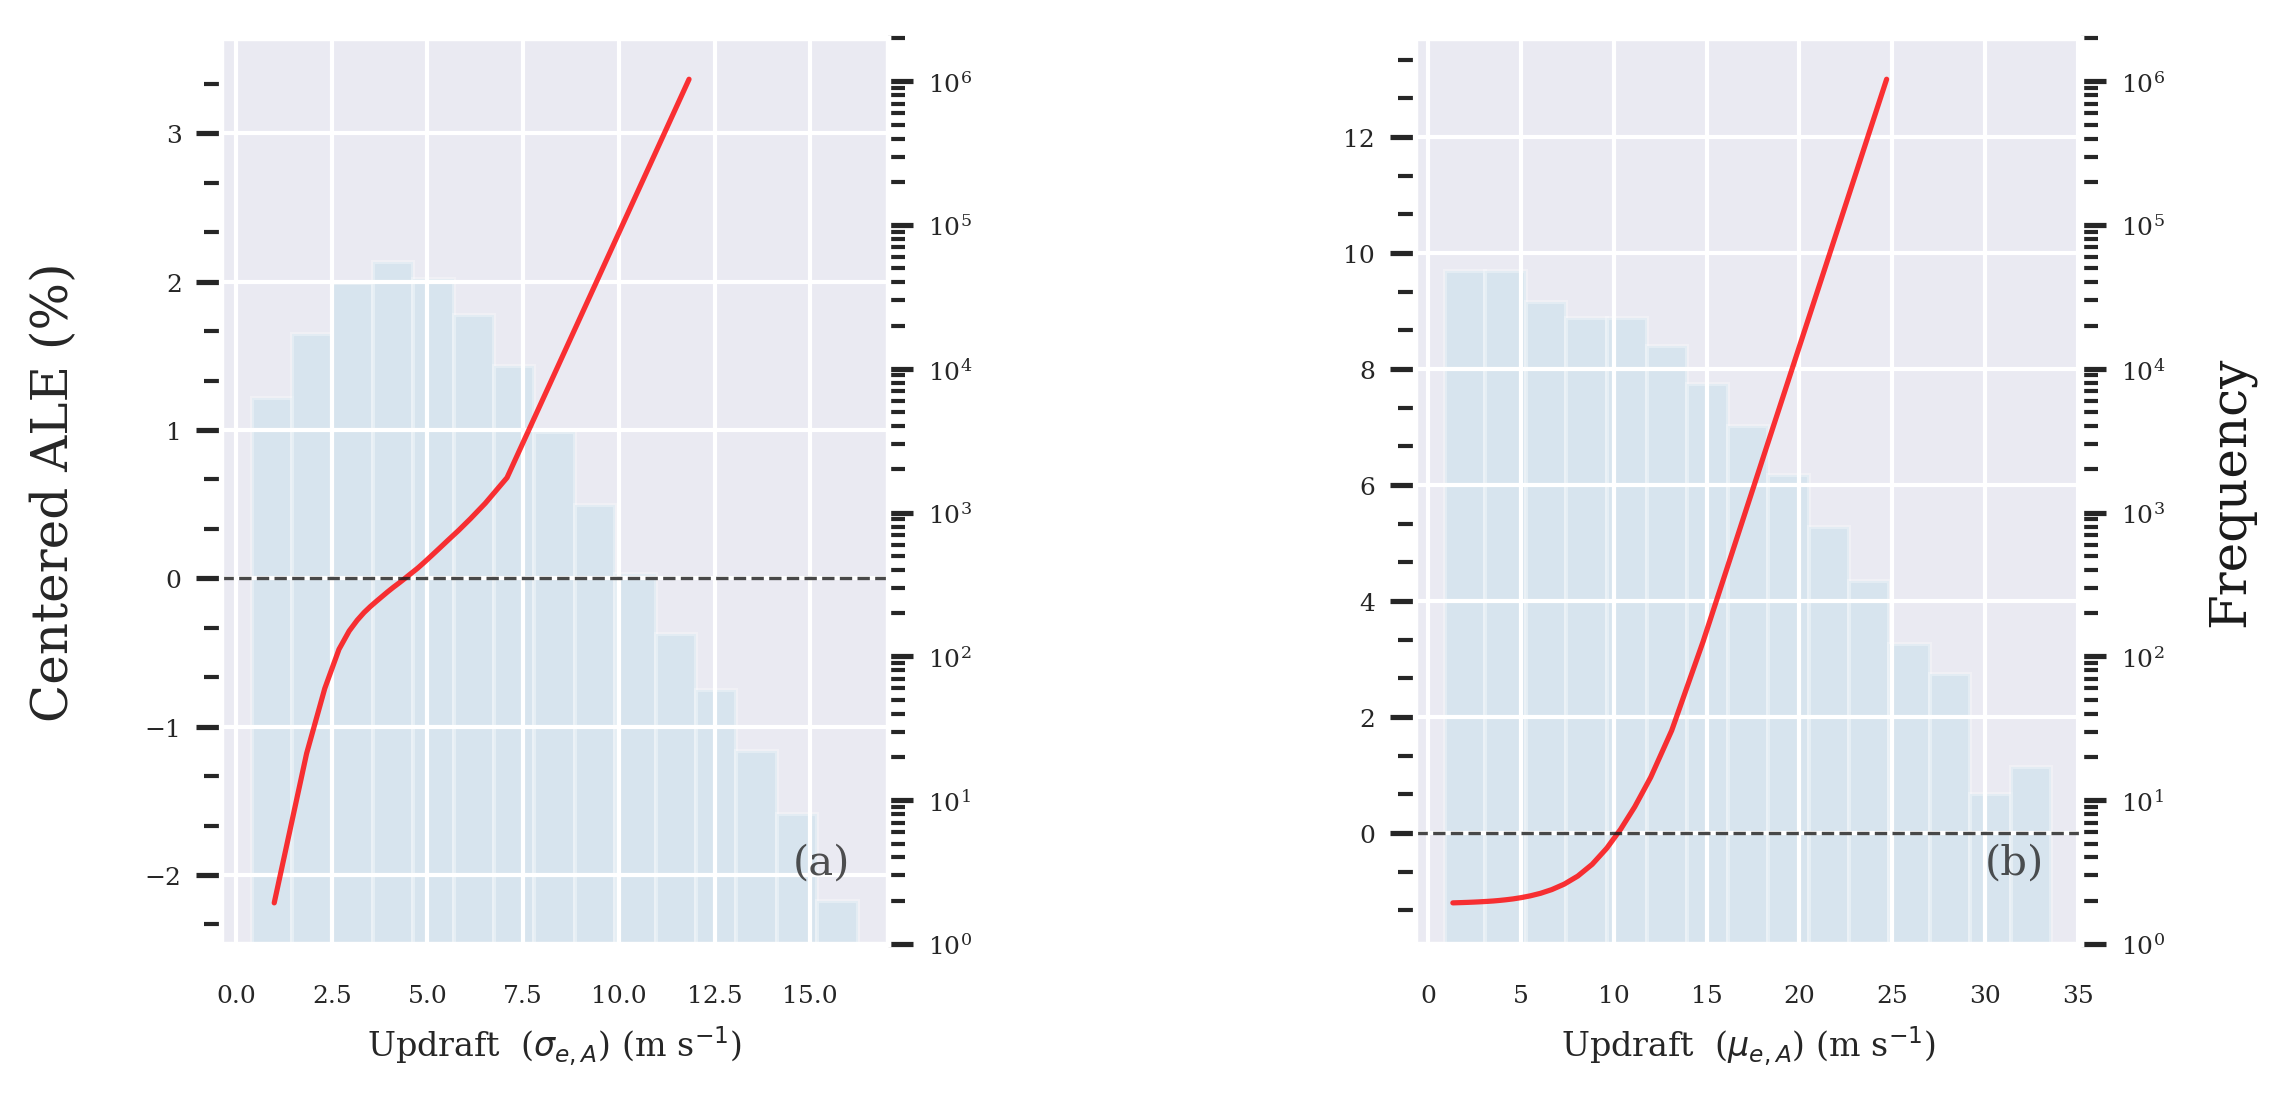

In [18]:
# Plot the ALE curve. 
explainer.plot_ale(ale_results, 
                   features = features,
                   estimator_names = 'LogisticRegression',
                   display_feature_names=display_feature_names,
                   display_units = display_units,
                   to_probability=True,
                   figsize=(8,4)
                      )

In [17]:
len(np.where(X['w_up_time_max_ens_mean_of_90th']>40)[0])

273